In [1]:
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
edges = [
    (0, 1, 0.2),  # Nœud 0 -> Nœud 1 avec un poids d'influence de 0.2
    (1, 2, 0.8),  # Nœud 1 -> Nœud 2 avec un poids d'influence de 0.8
    (1, 3, 0.6),  # Nœud 1 -> Nœud 3 avec un poids d'influence de 0.6
    (3, 4, 0.4)   # Nœud 3 -> Nœud 4 avec un poids d'influence de 0.4
]

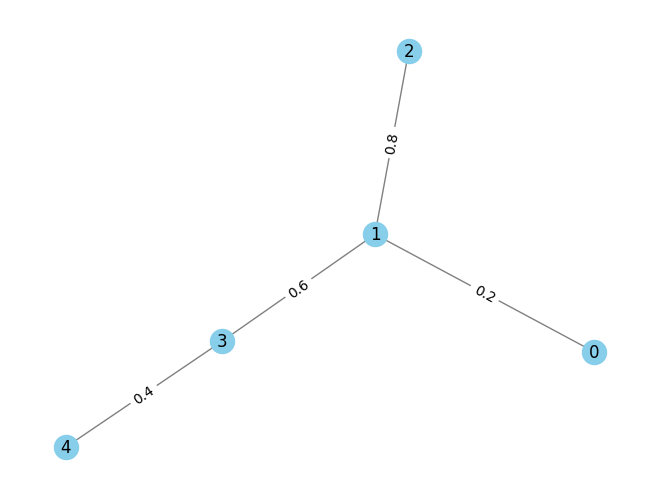

In [3]:


# Construire un graphe pondéré
G = nx.Graph()
for src, dst, weight in edges:
    G.add_edge(src, dst, weight=weight)

# Visualisation du graphe avec les arêtes pondérées
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray')
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()


In [4]:

# Caractéristiques des nœuds (seuils d'influence)
node_thresholds = {
    0: 0.3,  # Nœud 0 (seuil d'influence de 0.3)
    1: 0.5,  # Nœud 1 (seuil d'influence de 0.5)
    2: 0.7,  # Nœud 2 (seuil d'influence de 0.7)
    3: 0.4,  # Nœud 3 (seuil d'influence de 0.4)
    4: 0.6   # Nœud 4 (seuil d'influence de 0.6)
}

# Caractéristiques des nœuds (niveau de sécurité)
node_features = {
    0: [0.1],  # Nœud 0 (très vulnérable)
    1: [0.8],  # Nœud 1 (relativement sûr)
    2: [0.6],  # Nœud 2 (modérément vulnérable)
    3: [0.7],  # Nœud 3 (relativement sûr)
    4: [0.9]   # Nœud 4 (très sûr)
}


In [12]:
# Convertir les caractéristiques des nœuds en un format utilisable par PyTorch Geometric
import torch
from torch_geometric.data import Data

x = torch.tensor([node_features[node] for node in G.nodes], dtype=torch.float)

# Convertir le graphe en données PyTorch Geometric
edge_index = torch.tensor([[0, 1, 1, 2, 1, 3, 3, 4],
                           [1, 0, 2, 1, 3, 1, 4, 3]], dtype=torch.long)

# Données du graphe
data = Data(x=x, edge_index=edge_index)

In [14]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).sigmoid()
        return x

In [15]:
model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCELoss()

In [16]:
# 'entraînement (150 itérations)
for epoch in range(200):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out, torch.tensor([[1], [0], [0], [0], [0]], dtype=torch.float))  # Cible (infection initiale)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.7295082807540894
Epoch 2, Loss: 0.7173339128494263
Epoch 3, Loss: 0.7061460614204407
Epoch 4, Loss: 0.6968783140182495
Epoch 5, Loss: 0.6880386471748352
Epoch 6, Loss: 0.6796110272407532
Epoch 7, Loss: 0.6715718507766724
Epoch 8, Loss: 0.6639031171798706
Epoch 9, Loss: 0.6565814018249512
Epoch 10, Loss: 0.6495801210403442
Epoch 11, Loss: 0.6428512334823608
Epoch 12, Loss: 0.6363517045974731
Epoch 13, Loss: 0.6300469636917114
Epoch 14, Loss: 0.6239228248596191
Epoch 15, Loss: 0.6179446578025818
Epoch 16, Loss: 0.6121222972869873
Epoch 17, Loss: 0.6064399480819702
Epoch 18, Loss: 0.6008822917938232
Epoch 19, Loss: 0.5954349637031555
Epoch 20, Loss: 0.5900848507881165
Epoch 21, Loss: 0.584820032119751
Epoch 22, Loss: 0.5796416997909546
Epoch 23, Loss: 0.574540913105011
Epoch 24, Loss: 0.5694954991340637
Epoch 25, Loss: 0.5645027756690979
Epoch 26, Loss: 0.5595558285713196
Epoch 27, Loss: 0.5546585917472839
Epoch 28, Loss: 0.549811601638794
Epoch 29, Loss: 0.54501223564147

In [17]:
model.eval()
predictions = model(data.x, data.edge_index)
print(f"Prédictions : {predictions.detach().numpy()}")

Prédictions : [[0.26369822]
 [0.11608508]
 [0.18396653]
 [0.09157219]
 [0.1044096 ]]


In [18]:
def linear_threshold(G, initial_infected, node_thresholds):
    """
    Simule la diffusion d'une menace dans un graphe selon le modèle Linear Threshold.
    """
    newly_infected = set(initial_infected)
    total_infected = set(initial_infected)

    # Initialisation des influences des nœuds
    influence = {node: 0.0 for node in G.nodes}

    while newly_infected:
        next_infected = set()
        for node in newly_infected:
            for neighbor in G.neighbors(node):
                if neighbor not in total_infected:
                    # Additionner l'influence des nœuds voisins
                    influence[neighbor] += G[node][neighbor]['weight']

                    # Vérifier si la somme des influences dépasse le seuil
                    if influence[neighbor] >= node_thresholds[neighbor]:
                        next_infected.add(neighbor)

        total_infected.update(next_infected)
        newly_infected = next_infected

    return total_infected

# Exemple d'infection avec le modèle Linear Threshold
initial_infected = [0,2]
infected_nodes = linear_threshold(G, initial_infected, node_thresholds)
print(f"Nœuds infectés : {infected_nodes}")

Nœuds infectés : {0, 1, 2, 3}


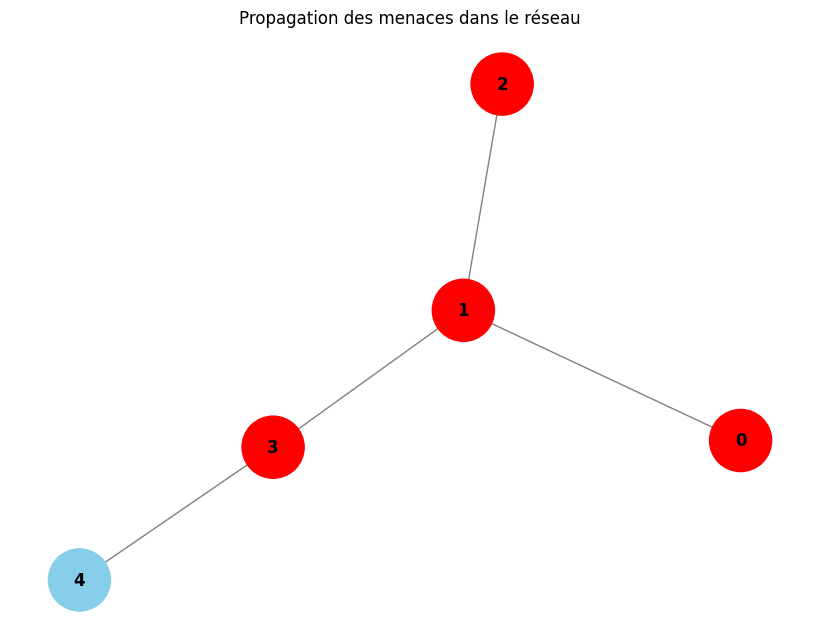

In [19]:
# Visualisation du graphe avec les nœuds infectés
pos = nx.spring_layout(G)

# Création des couleurs pour les nœuds
node_colors = ['red' if node in infected_nodes else 'skyblue' for node in G.nodes]

# Dessiner le graphe
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color=node_colors, edge_color='gray', node_size=2000, font_size=12, font_weight='bold')
plt.title("Propagation des menaces dans le réseau")
plt.show()

In [26]:
model_data = {
    'model': model,
    'linear_threshold': linear_threshold
}

# Enregistrer l'objet avec joblib
joblib.dump(model_data, 'model_menace.pkl')

['model_menace.pkl']